Celda 1: Imports y Carga de Artefactos

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import chess.pgn
import os
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
# Asegúrate de que estas rutas apunten a tus archivos
MODEL_PATH = "../trained_models/modelo_epoch_06.keras" 
TOKENIZER_PATH = "../trained_models/tokenizer.pkl"
MAX_SEQUENCE_LENGTH = 50
# --------------------

print("Cargando modelo y tokenizador...")
model = tf.keras.models.load_model(MODEL_PATH)
with open(TOKENIZER_PATH, 'rb') as f:
    tokenizer = pickle.load(f)
print("✅ Listo.")

model.summary()

C:\Repositorios_Locales\Proyectos_Personales\Bot_Ajedrez\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Repositorios_Locales\Proyectos_Personales\Bot_Ajedrez\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Repositorios_Locales\Proyectos_Personales\Bot_Ajedrez\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at te

Cargando modelo y tokenizador...
✅ Listo.


Model: "BotAjedrezRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ movimientos_input (InputLayer)       │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 300)             │       3,483,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 128)             │         219,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_1 (BatchNormalization)    │ (None, 50, 128)             │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_norm_2 (BatchNormalization)    │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_prediccion (Dense)            │ (None, 11610)               │       1,497,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,997,816 (61.03 MB)

 Trainable params: 5,332,434 (20.34 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 10,664,870 (40.68 MB)

Celda 2: Función de Predicción y Carga de la Partida

In [2]:
def predecir_siguientes_movimientos(sequence_text, top_k=10):
    sequence_num = tokenizer.texts_to_sequences([sequence_text])
    sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequence_num, maxlen=MAX_SEQUENCE_LENGTH, padding='post'
    )
    prediction = model.predict(sequence_padded, verbose=0)[0]
    top_indices = np.argsort(prediction)[-top_k:][::-1]
    predicted_moves = [tokenizer.index_word.get(i, "[DESCONOCIDO]") for i in top_indices]
    return predicted_moves

# Cargar la partida de prueba
pgn_file = open("../partida_test.pgn")
partida_test = chess.pgn.read_game(pgn_file)

# Convertimos la partida a una lista de jugadas en notación SAN
movimientos_reales = []
board = partida_test.board()
for move in partida_test.mainline_moves():
    movimientos_reales.append(board.san(move))
    board.push(move)

print(f"Partida de prueba cargada con {len(movimientos_reales)} jugadas.")

Partida de prueba cargada con 167 jugadas.


Celda 3: El Bucle de Testeo



In [3]:
resultados = []
# Analizamos la partida desde la jugada 5 hasta la 40, por ejemplo
for i in range(5, 41):
    historial_hasta_ahora = movimientos_reales[:i]
    jugada_correcta = movimientos_reales[i]
    
    # Pedimos las predicciones del bot
    predicciones_bot = predecir_siguientes_movimientos(historial_hasta_ahora, top_k=5)
    
    # Verificamos si la jugada correcta está en el Top-1, Top-3 o Top-5
    acierto_top1 = 1 if jugada_correcta == predicciones_bot[0] else 0
    acierto_top3 = 1 if jugada_correcta in predicciones_bot[:3] else 0
    acierto_top5 = 1 if jugada_correcta in predicciones_bot[:5] else 0
    
    resultados.append({
        "num_jugada": i + 1,
        "acierto_top1": acierto_top1,
        "acierto_top3": acierto_top3,
        "acierto_top5": acierto_top5
    })
    
    print(f"Jugada #{i+1}: Historial={historial_hasta_ahora[-3:]}... Jugada correcta='{jugada_correcta}', Top-5 Bot={predicciones_bot}")

print("\n✅ Análisis completado.")

Jugada #6: Historial=['Nc3', 'Nf6', 'Nf3']... Jugada correcta='Nc6', Top-5 Bot=['Nc6', 'Bc5', 'd6', 'Bb4', 'Be7']
Jugada #7: Historial=['Nf6', 'Nf3', 'Nc6']... Jugada correcta='g3', Top-5 Bot=['g3', 'e3', 'd4', 'd3', 'e4']
Jugada #8: Historial=['Nf3', 'Nc6', 'g3']... Jugada correcta='d5', Top-5 Bot=['Bc5', 'Bb4', 'Be7', 'd6', 'd5']
Jugada #9: Historial=['Nc6', 'g3', 'd5']... Jugada correcta='cxd5', Top-5 Bot=['cxd5', 'Bg2', 'd3', 'e3', 'd4']
Jugada #10: Historial=['g3', 'd5', 'cxd5']... Jugada correcta='Nxd5', Top-5 Bot=['Nxd5', 'e4', 'Qxd5', 'Nd4', 'Bb4']
Jugada #11: Historial=['d5', 'cxd5', 'Nxd5']... Jugada correcta='Bg2', Top-5 Bot=['Bg2', 'Nxd5', 'd3', 'e3', 'd4']
Jugada #12: Historial=['cxd5', 'Nxd5', 'Bg2']... Jugada correcta='Nb6', Top-5 Bot=['Be6', 'Nxc3', 'Bb4', 'Bc5', 'Bg4']
Jugada #13: Historial=['Nxd5', 'Bg2', 'Nb6']... Jugada correcta='O-O', Top-5 Bot=['O-O', 'd3', 'd4', 'e3', 'Nxe5']
Jugada #14: Historial=['Bg2', 'Nb6', 'O-O']... Jugada correcta='Be7', Top-5 Bot=['Be6', 

Celda 4: Visualización de Resultados

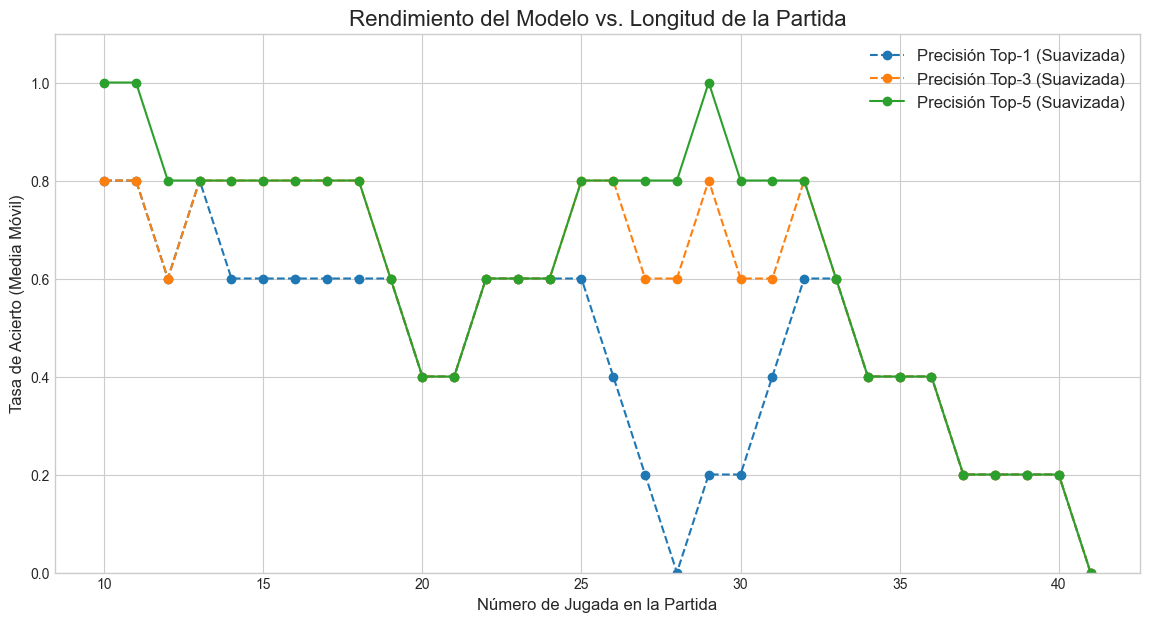

<Figure size 640x480 with 0 Axes>

In [7]:
import pandas as pd

df_resultados = pd.DataFrame(resultados)

# Usamos una media móvil para suavizar la gráfica y ver la tendencia
window_size = 5
df_resultados['top1_suavizado'] = df_resultados['acierto_top1'].rolling(window=window_size).mean()
df_resultados['top3_suavizado'] = df_resultados['acierto_top3'].rolling(window=window_size).mean()
df_resultados['top5_suavizado'] = df_resultados['acierto_top5'].rolling(window=window_size).mean()

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df_resultados['num_jugada'], df_resultados['top1_suavizado'], label='Precisión Top-1 (Suavizada)', marker='o', linestyle='--')
ax.plot(df_resultados['num_jugada'], df_resultados['top3_suavizado'], label='Precisión Top-3 (Suavizada)', marker='o', linestyle='--')
ax.plot(df_resultados['num_jugada'], df_resultados['top5_suavizado'], label='Precisión Top-5 (Suavizada)', marker='o', linestyle='-')

ax.set_title('Rendimiento del Modelo vs. Longitud de la Partida', fontsize=16)
ax.set_xlabel('Número de Jugada en la Partida', fontsize=12)
ax.set_ylabel('Tasa de Acierto (Media Móvil)', fontsize=12)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=12)

plt.show()
plt.savefig("mi_grafico.png")